In [1]:
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


from matplotlib.pyplot import imshow
from PIL import Image
from __future__ import print_function
from sklearn.utils import shuffle
import cv2
import h5py
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Using TensorFlow backend.


In [3]:
from sklearn.model_selection  import GridSearchCV

In [4]:
if not os.path.exists('models'):
    os.makedirs('models')
    
if not os.path.exists('submissions'):
    os.makedirs('submissions')
    
if not os.path.exists('weights'):
    os.makedirs('weights')

In [5]:
def data_train_extraction(folder_train):
        labels = [x[0].split('/')[-1] for x in os.walk(folder_train)][1:]
        TRAIN_FOLDER_ALL = [folder_train + '/' + x for x in labels]

        full_labels = list()
        imagepaths = list()

        n = 0
        for label in labels:
            for x in os.walk(TRAIN_FOLDER_ALL[n]):
                for y in x[2]:
                    imagepaths.append(TRAIN_FOLDER_ALL[n]+'/'+y)
                    full_labels.append(n)

            n += 1

        return imagepaths, full_labels, labels

def data_test_extraction(folder_test):
    images_test = [x for x in os.walk(folder_test)][0][2]
    TEST_FOLDER_ALL = [folder_test + '/' + x for x in images_test]

    return TEST_FOLDER_ALL

def load_m(model_n):
    model_l = load_model('models/{}.h5'.format(model_n))
    model_l.load_weights('weights/{}.h5'.format(model_n))
    return model_l

def submit(model, data, sub_name):
    path_test = [df_test['path'][i].split('/')[-1] for i in range(len(df_test['path']))]
    pr1 = model.predict(data)
    pr2 = label_binarizer.inverse_transform(pr1)
    names_pr = [number_to_names[str(i)] for i in pr2]
    submiss = pd.DataFrame({'file': path_test, 'species': names_pr})
    submiss.to_csv('submissions/{}'.format(sub_name), index=None)
    
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask
    
def proc_image0(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output
    
def proc_image1(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [6]:
imagepaths, full_labels, labels = data_train_extraction('data/train')

In [7]:
TEST_FOLDER_ALL = data_test_extraction('data/test')

In [8]:
TEST_FOLDER_ALL[:10]

['data/test/d0152bd7c.png',
 'data/test/fba8fc78a.png',
 'data/test/b573b7a56.png',
 'data/test/bebcaab66.png',
 'data/test/90d119d25.png',
 'data/test/8e29abce1.png',
 'data/test/7d3045fc3.png',
 'data/test/b4f7c9214.png',
 'data/test/5817b766d.png',
 'data/test/19fdf19fb.png']

In [9]:
imagepaths[:10]

['data/train/Common-wheat/2c4813e68.png',
 'data/train/Common-wheat/df584ca28.png',
 'data/train/Common-wheat/2f45d4b13.png',
 'data/train/Common-wheat/42098546c.png',
 'data/train/Common-wheat/96183ee02.png',
 'data/train/Common-wheat/4954fcb0d.png',
 'data/train/Common-wheat/cac003231.png',
 'data/train/Common-wheat/ec0d252e7.png',
 'data/train/Common-wheat/b398cfd9b.png',
 'data/train/Common-wheat/79f70b2d7.png']

In [10]:
full_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [11]:
labels

['Common-wheat',
 'Fat-Hen',
 'Small-flowered-Cranesbill',
 'Maize',
 'Scentless-Mayweed',
 'Cleavers',
 'Charlock',
 'Sugar-beet',
 'Shepherds-Purse',
 'Black-grass',
 'Common-Chickweed',
 'Loose-Silky-bent']

In [20]:
train = {'path': imagepaths, 'label': full_labels}
train = pd.DataFrame(train)

In [21]:
train.head()

,label,path
0,0,data/train/Common-wheat/2c4813e68.png
1,0,data/train/Common-wheat/df584ca28.png
2,0,data/train/Common-wheat/2f45d4b13.png
3,0,data/train/Common-wheat/42098546c.png
4,0,data/train/Common-wheat/96183ee02.png


In [22]:
test = {'path': TEST_FOLDER_ALL}
test = pd.DataFrame(test)

In [23]:
test.head()

,path
0,data/test/d0152bd7c.png
1,data/test/fba8fc78a.png
2,data/test/b573b7a56.png
3,data/test/bebcaab66.png
4,data/test/90d119d25.png


In [6]:
if not os.path.exists('data/df_data'):
    os.makedirs('data/df_data')
    
if not os.path.isfile('data/df_data/train.csv'):
    train.to_csv('data/df_data/train.csv', index=False)
else:
    df_train = pd.read_csv('data/df_data/train.csv')
    
if not os.path.isfile('data/df_data/test.csv'):
    test.to_csv('data/df_data/test.csv', index=False)
else:
    df_test = pd.read_csv('data/df_data/test.csv')

In [7]:
print(df_test.head(), '\n', df_train.head())

                      path
0  data/test/d0152bd7c.png
1  data/test/fba8fc78a.png
2  data/test/b573b7a56.png
3  data/test/bebcaab66.png
4  data/test/90d119d25.png 
    label                                   path
0      0  data/train/Common-wheat/2c4813e68.png
1      0  data/train/Common-wheat/df584ca28.png
2      0  data/train/Common-wheat/2f45d4b13.png
3      0  data/train/Common-wheat/42098546c.png
4      0  data/train/Common-wheat/96183ee02.png


In [8]:
number_to_names = {'0': 'Common wheat',
                  '1': 'Fat Hen',
                  '2': 'Small-flowered Cranesbill',
                  '3': 'Maize',
                  '4': 'Scentless Mayweed',
                   '5': 'Cleavers',
                  '6': 'Charlock',
                  '7': 'Sugar beet',
                  '8': 'Shepherds Purse',
                  '9': 'Black-grass',
                  '10': 'Common Chickweed',
                  '11': 'Loose Silky-bent'}

In [9]:
def image_edit(path, resolution):
    image = misc.imread(path)
    image = misc.imresize(image, (resolution, resolution), mode=None)
    return image

In [10]:
def image_edit0(path, resolution):
    img = cv2.imread(path)
    (b, g, r)=cv2.split(img)
    img=cv2.merge([r,g,b])
    image = misc.imresize(img, (resolution, resolution), mode=None)
    return image

/home/rodrigo/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


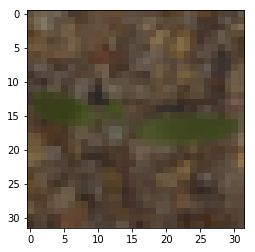

In [11]:
image0 = image_edit0('data/test/d0152bd7c.png', 32)
imshow(image0)

C:\Users\Rodrigo\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\Rodrigo\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


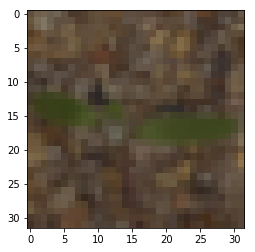

In [14]:
image = image_edit('data/test/d0152bd7c.png', 32)
imshow(image)

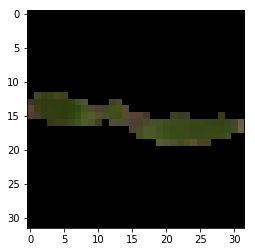

In [12]:
imshow(proc_image0(proc_image1(image0)))

In [23]:
# images_train = [proc_image0(proc_image1(image_edit0(path, 64))) for path in df_train['path']]

C:\Users\Rodrigo\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\Rodrigo\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [13]:
images_train = [image_edit0(path, 32) for path in df_train['path']]

/home/rodrigo/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [14]:
len(images_train)

4750

In [15]:
array_train = np.asarray(images_train)

In [16]:
# images_test = [proc_image0(proc_image1(image_edit0(path, 64))) for path in df_test['path']]

In [17]:
images_test = [image_edit0(path, 32) for path in df_test['path']]

/home/rodrigo/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [18]:
array_test = np.asarray(images_test)

In [19]:
X_train, X_test, y_train, y_test =train_test_split(array_train,
                                                   df_train['label'],
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify = df_train['label'])

In [20]:
X_train, y_train = shuffle(X_train, y_train)

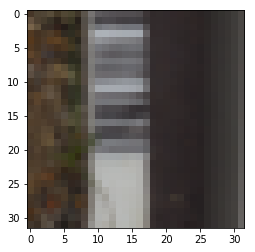

In [21]:
imshow(X_train[10])

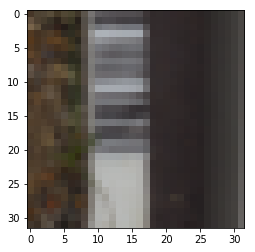

In [22]:
# im2display = X_train[10].transpose((1,20))
imshow(X_train[10], interpolation='nearest')

In [23]:
def histogram_equalize(img):
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

In [24]:
def normalize_scale(image_data):
    a = -0.5
    b = 0.5
    scale_min = 0
    scale_max = 255
    return a + ( ( (image_data - scale_min)*(b - a) )/( scale_max - scale_min ) )

In [25]:
def normalize_scale2(image_data):
    a = 0
    b = 0
    scale_min = 0
    scale_max = 255
    return a + ( ( (image_data - scale_min)*(b - a) )/( scale_max - scale_min ) )

In [26]:
def histogram_equalize_green(img):
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(b)
    blue = cv2.equalizeHist(b)
    green = cv2.equalizeHist(b)
    return cv2.merge((r, b, r))

In [27]:
X_normalized = normalize_scale(X_train)
X_normalized_test = normalize_scale(X_test)

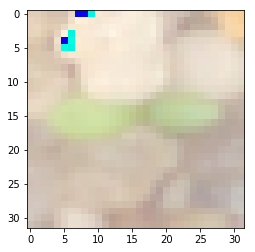

In [28]:
imshow(X_normalized[2])

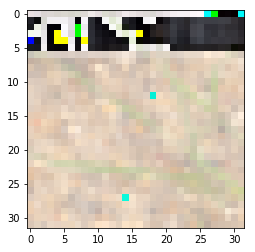

In [29]:
imshow(X_normalized_test[100])

In [68]:
img_data = [histogram_equalize(data) for data in images_train]
img_data = np.asarray(img_data)

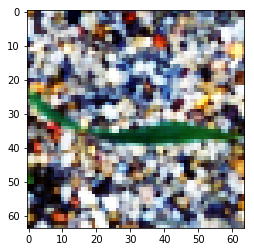

In [69]:
imshow(img_data[10])

In [70]:
X_train, X_test, y_train, y_test =train_test_split(img_data,
                                                   df_train['label'],
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify = df_train['label'])

In [72]:
X_equ = [histogram_equalize(data) for data in X_train]
X_equ = np.asarray(X_equ)

X_equ_test = [histogram_equalize(data) for data in X_test]
X_equ_test = np.asarray(X_equ_test)

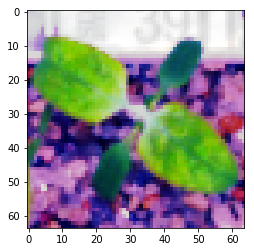

In [73]:
equ = histogram_equalize(X_equ[10])
imshow(equ)

In [30]:
test_normalized = normalize_scale(array_test)

In [31]:
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)
y_one_hot_test = label_binarizer.fit_transform(y_test)

In [32]:
y_train[:10]

3322     9
4        0
1823     4
4266    11
2576     6
614      1
4252    11
2730     7
442      1
4281    11
Name: label, dtype: int64

In [33]:
y_one_hot[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [34]:
y_back = label_binarizer.inverse_transform(y_one_hot[:10])

In [35]:
y_back

array([ 9,  0,  4, 11,  6,  1, 11,  7,  1, 11])

Primer intento

In [37]:
# Creación del modelo feedforward
model = Sequential()

# Esta capa aplana la entrada de 32x32x3 en un solo tensor de 3072
model.add(Flatten(input_shape=(32, 32, 3)))

# Esta añade una capa densamente conectada no es necesario indicarle el tamaño de entrada dado
# que no es la primera capa del modelo
model.add(Dense(20, activation="relu"))

# Capa densamente conectada en la que se indica el número de neuronas a la salida, que ha de 
# coincidir con el número de clases con las que se trabaja
model.add(Dense(12, activation="softmax"))

In [38]:
model.compile('SGD', 'categorical_crossentropy', ['accuracy'])
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
model.fit(X_normalized, y_one_hot, epochs=50, validation_split=0.20, verbose=2, callbacks=[earlyStopping])
# history = model.fit(X_train, y_one_hot, nb_epoch=10, validation_split=0.20, verbose=2)

Train on 3040 samples, validate on 760 samples
Epoch 1/50
 - 1s - loss: 2.4460 - acc: 0.1174 - val_loss: 2.4237 - val_acc: 0.1368
Epoch 2/50
 - 0s - loss: 2.4174 - acc: 0.1503 - val_loss: 2.4188 - val_acc: 0.1355
Epoch 3/50
 - 0s - loss: 2.4005 - acc: 0.1592 - val_loss: 2.3976 - val_acc: 0.1513
Epoch 4/50
 - 0s - loss: 2.3844 - acc: 0.1875 - val_loss: 2.3847 - val_acc: 0.1579
Epoch 5/50
 - 0s - loss: 2.3693 - acc: 0.1888 - val_loss: 2.3686 - val_acc: 0.1566
Epoch 6/50
 - 0s - loss: 2.3537 - acc: 0.2109 - val_loss: 2.3671 - val_acc: 0.2263
Epoch 7/50
 - 0s - loss: 2.3340 - acc: 0.2230 - val_loss: 2.3390 - val_acc: 0.2211
Epoch 8/50
 - 0s - loss: 2.3193 - acc: 0.2382 - val_loss: 2.3322 - val_acc: 0.2355
Epoch 9/50
 - 0s - loss: 2.3025 - acc: 0.2365 - val_loss: 2.3095 - val_acc: 0.2592
Epoch 10/50
 - 0s - loss: 2.2798 - acc: 0.2632 - val_loss: 2.2974 - val_acc: 0.2513
Epoch 11/50
 - 0s - loss: 2.2531 - acc: 0.2658 - val_loss: 2.2790 - val_acc: 0.2645
Epoch 12/50
 - 0s - loss: 2.2283 - acc

In [39]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

950/950 [==============================] - 0s 55us/step


[1.5819354857896504, 0.4600000003764504]

In [144]:
model_name = 'modelo1'
model.save_weights('weights/{}.h5'.format(model_name))
model.save('models/{}.h5'.format(model_name))

In [145]:
model_load = load_model('models/{}.h5'.format(model_name))
model_load.load_weights('weights/{}.h5'.format(model_name))
test_score = model_load.evaluate(X_normalized_test, y_one_hot_test)
test_score

950/950 [==============================] - 0s 379us/step


[1.343362095983405, 0.5105263151620564]

In [146]:
preds = model_load.predict(X_normalized_test)

In [147]:
predictions = label_binarizer.inverse_transform(preds)

In [148]:
predictions[:10]

array([10, 11,  4,  4, 10,  4, 10, 11, 11, 10])

In [149]:
cm = confusion_matrix(y_test, predictions)
cm

array([[  0,   1,   0,   0,   1,  11,   1,   1,   0,   1,   0,  28],
       [  0,  26,   5,   0,   7,   0,   4,  13,   2,   0,   7,  31],
       [  0,   4,  70,   1,   1,   0,  12,   3,   0,   0,   8,   0],
       [  0,   0,   1,  14,   6,   0,   5,   0,   0,   0,  18,   0],
       [  0,   3,   0,   1,  31,   1,  13,  24,   1,   1,  27,   1],
       [  0,   5,   4,   0,   0,  28,  16,   0,   0,   1,   1,   3],
       [  0,   0,   5,   0,   6,   5,  59,   1,   1,   0,   1,   0],
       [  0,   7,  12,   0,   8,   1,   0,  36,   1,   0,  10,   2],
       [  0,   0,   9,   0,  10,   4,   8,   1,   3,   0,  11,   0],
       [  0,   3,   0,   0,   0,   1,   0,   0,   0,   1,   2,  46],
       [  0,   1,   5,   1,  10,   3,   3,   2,   4,   0,  92,   1],
       [  0,   1,   1,   0,   1,   0,   0,   1,   0,   2,   0, 125]])

In [113]:
f1_score(y_test, predictions, average='macro')

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0539308309470563

In [103]:
names_preds = [number_to_names[str(i)] for i in predictions]

In [104]:
names_preds[:10]

['Charlock',
 'Scentless-Mayweed',
 'Charlock',
 'Charlock',
 'Charlock',
 'Charlock',
 'Charlock',
 'Loose-Silky-bent',
 'Loose-Silky-bent',
 'Charlock']

In [83]:
# Creación del modelo convolucional
model = Sequential()

# Capa de convilución. Recibe las dimensiones de la capa de entrada. Para imágenes se usa la capa de Convolution2D
model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation="relu"))

# Esta capa aplana la entrada de 32x32x3 en un solo tensor de 3072
model.add(Flatten())

# Esta añade una capa densamente conectada no es necesario indicarle el tamaño de entrada dado
# que no es la primera capa del modelo
model.add(Dense(128, activation="relu"))

# Capa densamente conectada en la que se indica el número de neuronas a la salida, que ha de 
# coincidir con el número de clases con las que se trabaja
model.add(Dense(12,activation="softmax"))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  """


In [84]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, epochs=20, validation_split=0.20, verbose=2, shuffle=True)

Train on 3040 samples, validate on 760 samples
Epoch 1/20
 - 4s - loss: 2.2997 - acc: 0.2316 - val_loss: 1.9593 - val_acc: 0.3750
Epoch 2/20
 - 4s - loss: 1.6435 - acc: 0.4493 - val_loss: 1.6022 - val_acc: 0.4237
Epoch 3/20
 - 4s - loss: 1.2650 - acc: 0.5724 - val_loss: 1.4367 - val_acc: 0.4816
Epoch 4/20
 - 4s - loss: 1.0002 - acc: 0.6678 - val_loss: 1.3582 - val_acc: 0.5263
Epoch 5/20
 - 4s - loss: 0.8247 - acc: 0.7299 - val_loss: 1.3121 - val_acc: 0.5697
Epoch 6/20
 - 4s - loss: 0.6377 - acc: 0.8072 - val_loss: 1.3983 - val_acc: 0.5697
Epoch 7/20
 - 4s - loss: 0.5102 - acc: 0.8490 - val_loss: 1.4699 - val_acc: 0.5474
Epoch 8/20
 - 4s - loss: 0.4067 - acc: 0.8868 - val_loss: 1.4420 - val_acc: 0.5658
Epoch 9/20
 - 4s - loss: 0.3055 - acc: 0.9237 - val_loss: 1.5523 - val_acc: 0.5711
Epoch 10/20
 - 4s - loss: 0.2241 - acc: 0.9569 - val_loss: 1.6031 - val_acc: 0.5671
Epoch 11/20
 - 4s - loss: 0.1715 - acc: 0.9651 - val_loss: 1.7700 - val_acc: 0.5671
Epoch 12/20
 - 4s - loss: 0.1179 - acc

In [85]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

950/950 [==============================] - 0s 313us/step


[2.314135516819201, 0.5421052625304774]

Modelo bueno

In [144]:
model = Sequential()

model.add(Convolution2D(16, 4, 4, input_shape=(64, 64, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

model.add(Convolution2D(32, 4, 4, activation="relu"))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

# model.add(Convolution2D(128, 4, 4, activation="relu"))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
# model.add(Dropout(0.25))

model.add(Dense(12, activation="softmax"))

BATCH_SIZE = 16
EPOCHS = 20
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
gen = ImageDataGenerator(
            rotation_range=360.,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0,
            horizontal_flip=True,
            vertical_flip=True
    )
model.fit_generator(gen.flow(X_normalized, y_one_hot,batch_size=BATCH_SIZE),
               steps_per_epoch=250,
               epochs=EPOCHS,
               verbose=1,
               shuffle=True,
               validation_data=(X_normalized_test, y_one_hot_test))


# batch_size = 16

#Cambiar E.S. por monitor = 'acc'
earlyStopping=keras.callbacks.EarlyStopping(monitor='acc', patience=4, verbose=1, mode='auto')

history = model.fit(X_normalized,
                    y_one_hot,
                    steps_per_epoch=20,
                    epochs=10,
                    verbose=1,
                    callbacks=[earlyStopping],
                   )

preds = model.predict(X_normalized_test)
predictions = label_binarizer.inverse_transform(preds)
f1_s = round(f1_score(y_test, predictions, average='micro'),4)

model_name = 'modelo_{}'.format(str(f1_s))
model.save_weights('weights/{}.h5'.format(model_name))
model.save('models/{}.h5'.format(model_name))

model_load = load_model('models/{}.h5'.format(model_name))
model_load.load_weights('weights/{}.h5'.format(model_name))
test_score = model_load.evaluate(X_normalized_test, y_one_hot_test)
test_score

submit(model_load, test_normalized, 'f1s_{}.csv'.format(str(f1_s))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (4, 4), activation="relu", input_shape=(64, 64, 3...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), activation="relu")`
  import sys


Epoch 1/20
250/250 [==============================] - 10s 40ms/step - loss: 2.0319 - acc: 0.2817 - val_loss: 1.6086 - val_acc: 0.4211
Epoch 2/20
250/250 [==============================] - 10s 38ms/step - loss: 1.6311 - acc: 0.4088 - val_loss: 1.4607 - val_acc: 0.4747
Epoch 3/20
250/250 [==============================] - 10s 38ms/step - loss: 1.4892 - acc: 0.4710 - val_loss: 1.3108 - val_acc: 0.5316
Epoch 4/20
250/250 [==============================] - 10s 38ms/step - loss: 1.4035 - acc: 0.5040 - val_loss: 1.2073 - val_acc: 0.5863
Epoch 5/20
250/250 [==============================] - 10s 38ms/step - loss: 1.3332 - acc: 0.5245 - val_loss: 1.2116 - val_acc: 0.5463
Epoch 6/20
250/250 [==============================] - 10s 38ms/step - loss: 1.3061 - acc: 0.5292 - val_loss: 1.1476 - val_acc: 0.5979
Epoch 7/20
250/250 [==============================] - 10s 39ms/step - loss: 1.2176 - acc: 0.5675 - val_loss: 1.1705 - val_acc: 0.6000
Epoch 8/20
250/250 [==============================] - 10s 39ms

[1.0280809711155139, 0.771578947619388]

In [146]:
submit(model_load, test_normalized, 'f1s_{}.csv'.format(str(f1_s)))

In [ ]:
#NO OLVIDAR HACER STACKING!!!!

In [44]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Convolution2D(32, 3, 3))
model.add(MaxPooling2D((2, 2)))
model.add(Convolution2D(64, 3, 3))
model.add(MaxPooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(12,activation="sigmoid"))


batch_size = 16

BATCH_SIZE = 16
EPOCHS = 20
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
gen = ImageDataGenerator(
            rotation_range=360.,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=False,
            vertical_flip=False
    )
model.fit_generator(gen.flow(X_normalized, y_one_hot,batch_size=BATCH_SIZE),
               steps_per_epoch=200,
               epochs=EPOCHS,
               verbose=1,
               shuffle=True,
               validation_data=(X_normalized_test, y_one_hot_test))

#Cambiar E.S. por monitor = 'acc'
earlyStopping=keras.callbacks.EarlyStopping(monitor='acc', patience=4, verbose=1, mode='auto')

history = model.fit(X_normalized,
                    y_one_hot,
                    steps_per_epoch=50,
                    epochs=60,
                    callbacks=[earlyStopping],
                   )

model_name = 'modelo4'
model.save_weights('weights/{}.h5'.format(model_name))
model.save('models/{}.h5'.format(model_name))

model_load = load_model('models/{}.h5'.format(model_name))
model_load.load_weights('weights/{}.h5'.format(model_name))
test_score = model_load.evaluate(X_normalized_test, y_one_hot_test)
test_score

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3...)`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  


Epoch 1/20
200/200 [==============================] - 2s 12ms/step - loss: 2.3811 - acc: 0.1675 - val_loss: 2.1464 - val_acc: 0.2358
Epoch 2/20
200/200 [==============================] - 2s 10ms/step - loss: 1.9668 - acc: 0.2903 - val_loss: 1.8590 - val_acc: 0.3316
Epoch 3/20
200/200 [==============================] - 2s 11ms/step - loss: 1.8243 - acc: 0.3444 - val_loss: 1.6375 - val_acc: 0.4126
Epoch 4/20
200/200 [==============================] - 2s 11ms/step - loss: 1.6803 - acc: 0.4103 - val_loss: 1.5337 - val_acc: 0.4505
Epoch 5/20
200/200 [==============================] - 2s 10ms/step - loss: 1.5943 - acc: 0.4425 - val_loss: 1.4492 - val_acc: 0.4768
Epoch 6/20
200/200 [==============================] - 2s 10ms/step - loss: 1.5296 - acc: 0.4503 - val_loss: 1.5854 - val_acc: 0.4389
Epoch 7/20
200/200 [==============================] - 2s 10ms/step - loss: 1.4461 - acc: 0.4897 - val_loss: 1.3172 - val_acc: 0.5147
Epoch 8/20
200/200 [==============================] - 2s 11ms/step - 

[1.0009187151883778, 0.8031578946113587]

In [109]:
model_name = 'modelo6'
model_load = load_m(model_name)

In [115]:
preds = model_load.predict(X_normalized_test)

In [116]:
predictions = label_binarizer.inverse_transform(preds)

In [117]:
predictions[:10]

array([10,  9,  4,  4, 10,  4, 10,  0, 11,  4])

In [118]:
cm = confusion_matrix(y_test, predictions)
cm

array([[  9,   2,   0,   0,   1,   6,   0,   0,   0,   3,   0,  23],
       [  1,  47,   1,   0,   5,   0,   2,   8,   2,   0,   9,  20],
       [  0,   0,  76,   2,   0,   1,  11,   6,   1,   0,   2,   0],
       [  0,   0,   1,  19,  12,   0,   3,   0,   0,   0,   9,   0],
       [  1,   3,   0,   2,  64,   1,   6,   8,   1,   0,  12,   5],
       [  5,   0,   2,   0,   0,  44,   4,   0,   0,   0,   1,   2],
       [  1,   2,   3,   1,   5,   7,  59,   0,   0,   0,   0,   0],
       [  1,   5,  10,   2,  13,   0,   0,  41,   1,   0,   4,   0],
       [  0,   0,   4,   0,   9,   2,   4,   2,  20,   0,   5,   0],
       [  0,   0,   0,   0,   2,   0,   0,   1,   0,   5,   0,  45],
       [  0,   0,   3,   2,   6,   0,   2,   1,   5,   0, 102,   1],
       [  0,   1,   0,   0,   1,   0,   0,   1,   0,   8,   0, 120]])

In [119]:
f1_score(y_test, predictions, average='micro')

0.6378947368421053

In [96]:
names_preds = [number_to_names[str(i)] for i in predictions]

In [97]:
names_preds[:10]

['Common Chickweed',
 'Loose Silky-bent',
 'Maize',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Loose Silky-bent',
 'Scentless Mayweed']

In [112]:
# test_normalized
def submit(model, data, sub_name):
    path_test = [df_test['path'][i].split('/')[-1] for i in range(len(df_test['path']))]
    pr1 = model.predict(data)
    pr2 = label_binarizer.inverse_transform(pr1)
    names_pr = [number_to_names[str(i)] for i in pr2]
    submiss = pd.DataFrame({'file': path_test, 'species': names_pr})
    submiss.to_csv('submissions/{}'.format(sub_name), index=None)

In [113]:
submit(model_load, test_normalized, 'sexto.csv')

In [ ]:
preds_sub = model_load.predict(df_test['path'])

In [89]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Convolution2D(32, 3, 3))
model.add(MaxPooling2D((2, 2)))
model.add(Convolution2D(64, 3, 3))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(12,activation="sigmoid"))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., activation="relu")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  


In [94]:
batch_size = 16
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized,
                    y_one_hot,
                    steps_per_epoch=(2000 // batch_size),
                    epochs=50
                   )
model.save_weights('weights/first_try.h5')
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

Epoch 1/50
125/125 [==============================] - 195s 2s/step - loss: 1.8430 - acc: 0.3354
Epoch 2/50
125/125 [==============================] - 194s 2s/step - loss: 1.0094 - acc: 0.6440
Epoch 3/50
125/125 [==============================] - 191s 2s/step - loss: 0.6408 - acc: 0.7812
Epoch 4/50
125/125 [==============================] - 192s 2s/step - loss: 0.4275 - acc: 0.8566
Epoch 5/50
125/125 [==============================] - 191s 2s/step - loss: 0.2986 - acc: 0.9013
Epoch 6/50
125/125 [==============================] - 193s 2s/step - loss: 0.2122 - acc: 0.9314
Epoch 7/50
125/125 [==============================] - 192s 2s/step - loss: 0.1580 - acc: 0.9497
Epoch 8/50
125/125 [==============================] - 191s 2s/step - loss: 0.1199 - acc: 0.9627
Epoch 9/50
125/125 [==============================] - 192s 2s/step - loss: 0.0903 - acc: 0.9727
Epoch 10/50
125/125 [==============================] - 192s 2s/step - loss: 0.0703 - acc: 0.9799
Epoch 11/50
125/125 [==================

ImportError: `save_weights` requires h5py.

In [110]:
model.save('models/my_model.h5')

ImportError: `save_model` requires h5py.

In [111]:
# model.save_weights('weights/first_try.h5')
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

950/950 [==============================] - 0s 186us/step


[nan, 0.04631578947368421]

In [59]:


# Creación del modelo convolucional con pooling
model = Sequential()

# Capa de convolución. Recibe las dimensiones de la capa de entrada. Para imágenes se usa la capa de Convolution2D
model.add(Convolution2D(32, 3, 3, input_shape=(20, 20, 3), activation="relu"))

# Capa de pooling para datos espaciales, tamaño de ventana 2x2
model.add(MaxPooling2D((3, 3)))

model.add(Flatten())

# Esta añade una capa densamente conectada no es necesario indicarle el tamaño de entrada dado
# que no es la primera capa del modelo
model.add(Dense(128, activation="relu"))

# Capa densamente conectada en la que se indica el número de neuronas a la salida, que ha de 
# coincidir con el número de clases con las que se trabaja
model.add(Dense(12, activation="softmax"))



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(20, 20, 3...)`
  import sys


In [60]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

/usr/local/lib/python3.5/dist-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3040 samples, validate on 760 samples
Epoch 1/20
 - 1s - loss: 2.3883 - acc: 0.1724 - val_loss: 2.2475 - val_acc: 0.2632
Epoch 2/20
 - 1s - loss: 2.1200 - acc: 0.2905 - val_loss: 1.8966 - val_acc: 0.3368
Epoch 3/20
 - 1s - loss: 1.7709 - acc: 0.3839 - val_loss: 1.6285 - val_acc: 0.4211
Epoch 4/20
 - 1s - loss: 1.5503 - acc: 0.4615 - val_loss: 1.5131 - val_acc: 0.4632
Epoch 5/20
 - 1s - loss: 1.4217 - acc: 0.5056 - val_loss: 1.3870 - val_acc: 0.5263
Epoch 6/20
 - 1s - loss: 1.3085 - acc: 0.5444 - val_loss: 1.3932 - val_acc: 0.4961
Epoch 7/20
 - 1s - loss: 1.2389 - acc: 0.5717 - val_loss: 1.3465 - val_acc: 0.5066
Epoch 8/20
 - 1s - loss: 1.1992 - acc: 0.5720 - val_loss: 1.2919 - val_acc: 0.5408
Epoch 9/20
 - 1s - loss: 1.1251 - acc: 0.6207 - val_loss: 1.2644 - val_acc: 0.5395
Epoch 10/20
 - 1s - loss: 1.0712 - acc: 0.6414 - val_loss: 1.3313 - val_acc: 0.5513
Epoch 11/20
 - 1s - loss: 1.0435 - acc: 0.6441 - val_loss: 1.2277 - val_acc: 0.5539
Epoch 12/20
 - 1s - loss: 0.9887 - acc

In [65]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

AttributeError: 'KerasClassifier' object has no attribute 'evaluate'

In [103]:
# Creación del modelo convolucional con pooling
model = Sequential()

# Capa de convolución. Recibe las dimensiones de la capa de entrada. Para imágenes se usa la capa de Convolution2D
model.add(Convolution2D(8, 4, 4, input_shape=(32, 32, 3), activation="relu"))

# Capa de pooling para datos espaciales, tamaño de ventana 2x2
model.add(MaxPooling2D((2, 2)))

# Capa de dropout para favorecer la capacidad de generalización
model.add(Dropout(0.25))

# Capa de convolución. Recibe las dimensiones de la capa de entrada. Para imágenes se usa la capa de Convolution2D
model.add(Convolution2D(16, 4, 4, activation="relu"))

# Capa de pooling para datos espaciales, tamaño de ventana 2x2
model.add(MaxPooling2D((2, 2)))

# Capa de dropout para favorecer la capacidad de generalización
model.add(Dropout(0.5))

# Esta capa aplana la entrada de 32x32x3 en un solo tensor de 3072
model.add(Flatten())

# Esta añade una capa densamente conectada no es necesario indicarle el tamaño de entrada dado
# que no es la primera capa del modelo

model.add(Dense(512, activation="relu"))

# Capa densamente conectada en la que se indica el número de neuronas a la salida, que ha de 
# coincidir con el número de clases con las que se trabaja
model.add(Dense(12, activation="softmax"))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (4, 4), activation="relu", input_shape=(32, 32, 3...)`
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (4, 4), activation="relu")`
  


In [104]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

/usr/local/lib/python3.5/dist-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3040 samples, validate on 760 samples
Epoch 1/20
 - 1s - loss: 2.4078 - acc: 0.1398 - val_loss: 2.3590 - val_acc: 0.1724
Epoch 2/20
 - 1s - loss: 2.2754 - acc: 0.2056 - val_loss: 2.2599 - val_acc: 0.2263
Epoch 3/20
 - 1s - loss: 1.9536 - acc: 0.3339 - val_loss: 1.8605 - val_acc: 0.3368
Epoch 4/20
 - 1s - loss: 1.6813 - acc: 0.4227 - val_loss: 1.5331 - val_acc: 0.4355
Epoch 5/20
 - 1s - loss: 1.5462 - acc: 0.4559 - val_loss: 1.4664 - val_acc: 0.4895
Epoch 6/20
 - 1s - loss: 1.4307 - acc: 0.4836 - val_loss: 1.3033 - val_acc: 0.5434
Epoch 7/20
 - 1s - loss: 1.3615 - acc: 0.5230 - val_loss: 1.2294 - val_acc: 0.5566
Epoch 8/20
 - 1s - loss: 1.3116 - acc: 0.5388 - val_loss: 1.2709 - val_acc: 0.5921
Epoch 9/20
 - 1s - loss: 1.2671 - acc: 0.5451 - val_loss: 1.1464 - val_acc: 0.6145
Epoch 10/20
 - 1s - loss: 1.2165 - acc: 0.5661 - val_loss: 1.1110 - val_acc: 0.5974
Epoch 11/20
 - 1s - loss: 1.2066 - acc: 0.5674 - val_loss: 1.1341 - val_acc: 0.6079
Epoch 12/20
 - 1s - loss: 1.1853 - acc

In [105]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

950/950 [==============================] - 0s 130us/step


[0.9969485611664621, 0.6410526314534639]

In [182]:


# Creación del modelo convolucional con pooling
model = Sequential()

model.add(Convolution2D(32, 4, 4, input_shape=(32, 32, 3), activation="relu"))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 4, 4, activation="relu"))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation="relu"))

model.add(Dense(12, activation="softmax"))



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), activation="relu", input_shape=(32, 32, 3...)`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.


In [183]:
BATCH_SIZE = 16
EPOCHS = 20
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
gen = ImageDataGenerator(
            rotation_range=360.,
            width_shift_range=0.5,
            height_shift_range=0.5,
            zoom_range=0.5,
            horizontal_flip=True,
            vertical_flip=True
    )
model.fit_generator(gen.flow(X_normalized, y_one_hot,batch_size=BATCH_SIZE),
               steps_per_epoch=500,
               epochs=EPOCHS,
               verbose=1,
               shuffle=True,
               validation_data=(X_normalized_test, y_one_hot_test))

Epoch 1/20
500/500 [==============================] - 6s 12ms/step - loss: 2.3103 - acc: 0.1834 - val_loss: 2.0248 - val_acc: 0.2779
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 2.0613 - acc: 0.2768 - val_loss: 1.9283 - val_acc: 0.3263
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 1.9388 - acc: 0.3244 - val_loss: 1.6577 - val_acc: 0.4274
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 1.8514 - acc: 0.3601 - val_loss: 1.5908 - val_acc: 0.4221
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 1.8315 - acc: 0.3605 - val_loss: 1.5421 - val_acc: 0.4716
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 1.7772 - acc: 0.3747 - val_loss: 1.6871 - val_acc: 0.3779
Epoch 7/20
500/500 [==============================] - 5s 10ms/step - loss: 1.7571 - acc: 0.3806 - val_loss: 1.4409 - val_acc: 0.4916
Epoch 8/20
500/500 [==============================] - 5s 10ms/step - 

In [184]:
# model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

Train on 3040 samples, validate on 760 samples
Epoch 1/20


/usr/local/lib/python3.5/dist-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


 - 1s - loss: 1.2189 - acc: 0.5589 - val_loss: 1.0864 - val_acc: 0.6329
Epoch 2/20
 - 1s - loss: 1.1228 - acc: 0.6033 - val_loss: 0.9824 - val_acc: 0.6579
Epoch 3/20
 - 1s - loss: 1.0847 - acc: 0.6036 - val_loss: 1.0050 - val_acc: 0.6605
Epoch 4/20
 - 1s - loss: 1.0460 - acc: 0.6201 - val_loss: 0.9675 - val_acc: 0.6566
Epoch 5/20
 - 1s - loss: 1.0232 - acc: 0.6339 - val_loss: 0.9408 - val_acc: 0.6816
Epoch 6/20
 - 1s - loss: 0.9830 - acc: 0.6516 - val_loss: 0.9891 - val_acc: 0.6329
Epoch 7/20
 - 1s - loss: 0.9611 - acc: 0.6582 - val_loss: 0.9478 - val_acc: 0.6487
Epoch 8/20
 - 1s - loss: 0.9413 - acc: 0.6664 - val_loss: 0.8722 - val_acc: 0.6829
Epoch 9/20
 - 1s - loss: 0.9347 - acc: 0.6678 - val_loss: 0.8652 - val_acc: 0.6974
Epoch 10/20
 - 1s - loss: 0.9235 - acc: 0.6757 - val_loss: 0.8336 - val_acc: 0.7039
Epoch 11/20
 - 1s - loss: 0.9096 - acc: 0.6770 - val_loss: 0.9552 - val_acc: 0.6276
Epoch 12/20
 - 1s - loss: 0.8762 - acc: 0.7000 - val_loss: 0.8493 - val_acc: 0.6895
Epoch 13/20


In [185]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

950/950 [==============================] - 0s 158us/step


[0.865764540120175, 0.7084210528825459]

In [149]:
test_score[1]

0.7231578946113586

In [150]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(12, activation="softmax"))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  after removing the cwd from sys.path.


In [155]:
from keras.preprocessing.image import ImageDataGenerator

In [160]:
BATCH_SIZE = 16
EPOCHS = 5
gen = ImageDataGenerator(
            rotation_range=360.,
            width_shift_range=0.3,
            height_shift_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True
    )
model.fit_generator(gen.flow(X_normalized, y_one_hot,batch_size=BATCH_SIZE),
               steps_per_epoch=100,
               epochs=EPOCHS,
               verbose=1,
               shuffle=True,
               validation_data=(X_normalized_test, y_one_hot_test))

Epoch 1/5
100/100 [==============================] - 8s 76ms/step - loss: 1.2468 - acc: 0.5713 - val_loss: 1.0129 - val_acc: 0.6547
Epoch 2/5
100/100 [==============================] - 8s 75ms/step - loss: 1.2271 - acc: 0.5637 - val_loss: 0.9720 - val_acc: 0.6768
Epoch 3/5
100/100 [==============================] - 8s 75ms/step - loss: 1.2022 - acc: 0.5906 - val_loss: 0.9438 - val_acc: 0.6926
Epoch 4/5
100/100 [==============================] - 8s 76ms/step - loss: 1.1752 - acc: 0.5913 - val_loss: 1.0310 - val_acc: 0.6442
Epoch 5/5
100/100 [==============================] - 8s 76ms/step - loss: 1.1936 - acc: 0.5912 - val_loss: 0.9411 - val_acc: 0.7116


In [161]:
model.compile("adam", 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch=20, validation_split=0.20, verbose=2, shuffle=True)

/usr/local/lib/python3.5/dist-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3040 samples, validate on 760 samples
Epoch 1/20
 - 9s - loss: 0.7496 - acc: 0.7306 - val_loss: 0.7816 - val_acc: 0.7447
Epoch 2/20
 - 8s - loss: 0.3566 - acc: 0.8885 - val_loss: 0.6751 - val_acc: 0.7921
Epoch 3/20
 - 8s - loss: 0.1938 - acc: 0.9368 - val_loss: 0.8933 - val_acc: 0.7553
Epoch 4/20
 - 8s - loss: 0.1275 - acc: 0.9569 - val_loss: 0.8678 - val_acc: 0.7697
Epoch 5/20
 - 8s - loss: 0.0925 - acc: 0.9704 - val_loss: 0.8975 - val_acc: 0.7947
Epoch 6/20
 - 8s - loss: 0.0706 - acc: 0.9773 - val_loss: 1.0798 - val_acc: 0.7539
Epoch 7/20
 - 8s - loss: 0.0584 - acc: 0.9813 - val_loss: 0.9133 - val_acc: 0.7974
Epoch 8/20
 - 9s - loss: 0.0643 - acc: 0.9793 - val_loss: 0.9538 - val_acc: 0.7724
Epoch 9/20
 - 9s - loss: 0.0543 - acc: 0.9832 - val_loss: 0.9795 - val_acc: 0.7789
Epoch 10/20
 - 8s - loss: 0.0706 - acc: 0.9773 - val_loss: 1.0376 - val_acc: 0.7882
Epoch 11/20
 - 9s - loss: 0.0362 - acc: 0.9888 - val_loss: 1.0725 - val_acc: 0.7763
Epoch 12/20
 - 9s - loss: 0.0333 - acc

In [162]:
test_score = model.evaluate(X_normalized_test, y_one_hot_test)
test_score

950/950 [==============================] - 0s 486us/step


[1.5361323025352076, 0.7178947367166219]